In [1]:
#1 Initialize Environment and Import Core Libraries

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
!pip install lifelines
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 7.6 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=262dc84349de981362d8cf96df0e5421a157452d2b986b6f577fe3a4dac64d5d
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


**Step#1** This foundational step sets up the computational environment by importing essential libraries for data manipulation, visualization, preprocessing, and survival analysis. It includes os for path handling, pandas for dataframes, matplotlib.pyplot and seaborn for plotting, and LabelEncoder and StandardScaler from sklearn.preprocessing for encoding and scaling features. The lifelines package is installed and verified, enabling survival modeling via CoxPHFitter, KaplanMeierFitter, and concordance_index. This ensures all dependencies are satisfied and the environment is ready for clinical data analysis workflows.

In [2]:
#2 Link Colab to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Step#2** This step connects the Google Colab environment to the user's Google Drive, enabling persistent access to files across sessions. By importing drive from google.colab and executing drive.mount('/content/drive'), the notebook prompts authorization and mounts the Drive at the specified path. The output confirms that the Drive is already mounted, ensuring that datasets, outputs, and models stored in Drive can be read from and written to seamlessly. This setup is essential for reproducibility, collaboration, and long-term storage in cloud-based workflows.

In [3]:
#3 Set Paths for Dataset and Output Storage

import os # Import os for path manipulation
project_root = '/content/drive/MyDrive/METABRIC_project'
data_path = '/content/drive/MyDrive/METABRIC_cleaned_imputed.csv' # Corrected path
output_path = os.path.join(project_root, 'outputs')

**Step#3** This step establishes the directory structure for the METABRIC analysis workflow by defining key file paths. It begins by importing the os module to enable robust path manipulation. The project_root variable points to the main project folder in Google Drive, while data_path specifies the location of the cleaned and imputed METABRIC dataset. The output_path is constructed by appending an outputs subdirectory to the project root, creating a dedicated space for saving plots, model summaries, and other artifacts. This setup ensures clarity, modularity, and reproducibility throughout the pipeline.

In [4]:
#4 Load Dataset and Explore Feature Schema

import pandas as pd

# Ensure data_path is defined if this cell is run independently
data_path = '/content/drive/MyDrive/METABRIC_cleaned_imputed.csv'

# Load dataset
df = pd.read_csv(data_path)

# Display column names
print("Column names in the dataset:")
print(df.columns)

Column names in the dataset:
Index(['Patient ID', 'Age at Diagnosis', 'Type of Breast Surgery',
       'Cancer Type', 'Cancer Type Detailed', 'Cellularity', 'Chemotherapy',
       'Pam50 + Claudin-low subtype', 'Cohort', 'ER status measured by IHC',
       'ER Status', 'Neoplasm Histologic Grade',
       'HER2 status measured by SNP6', 'HER2 Status',
       'Tumor Other Histologic Subtype', 'Hormone Therapy',
       'Inferred Menopausal State', 'Integrative Cluster',
       'Primary Tumor Laterality', 'Lymph nodes examined positive',
       'Mutation Count', 'Nottingham prognostic index', 'Oncotree Code',
       'Overall Survival (Months)', 'Overall Survival Status', 'PR Status',
       'Radio Therapy', 'Relapse Free Status (Months)', 'Relapse Free Status',
       'Sex', '3-Gene classifier subtype', 'Tumor Size', 'Tumor Stage',
       'Patient's Vital Status'],
      dtype='object')


**Step#4** In this step, the METABRIC breast cancer dataset is loaded using pandas.read_csv() from a specified path (/content/drive/MyDrive/METABRIC_cleaned_imputed.csv). The dataset is stored in a DataFrame named df, and its schema is inspected by printing the column names. This reveals the structure and available features, including patient demographics, tumor characteristics, treatment modalities, molecular subtypes, and survival outcomes. Understanding the schema is essential for downstream preprocessing, feature selection, and modeling decisions in clinical data science workflows.

In [5]:
#5 Initial Patient Record Inspection

display(df.head())

,Patient ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,...,Overall Survival Status,PR Status,Radio Therapy,Relapse Free Status (Months),Relapse Free Status,Sex,3-Gene classifier subtype,Tumor Size,Tumor Stage,Patient's Vital Status
0,MB-0000,76,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,High,No,claudin-low,1.0,Positve,...,Living,Negative,Yes,139,Not Recurred,Female,ER-/HER2-,22.0,2.0,Living
1,MB-0002,43,Breast Conserving,Breast Cancer,Breast Invasive Ductal Carcinoma,High,No,LumA,1.0,Positve,...,Living,Positive,Yes,84,Not Recurred,Female,ER+/HER2- High Prolif,10.0,1.0,Living
2,MB-0005,49,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,High,Yes,LumB,1.0,Positve,...,Deceased,Positive,No,151,Recurred,Female,ER+/HER2- Low Prolif,15.0,2.0,Died of Disease
3,MB-0006,48,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,Yes,LumB,1.0,Positve,...,Living,Positive,Yes,163,Not Recurred,Female,ER+/HER2- Low Prolif,25.0,2.0,Living
4,MB-0008,77,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,Yes,LumB,1.0,Positve,...,Deceased,Positive,Yes,19,Recurred,Female,ER+/HER2- High Prolif,40.0,2.0,Died of Disease


**Step#5** This step uses display(df.head()) to preview the first five rows of the METABRIC dataset, offering a snapshot of individual patient records. Each row corresponds to a unique patient and includes 34 clinical and molecular attributes such as age at diagnosis, type of breast surgery, tumor subtype, hormone receptor status, treatment history, and survival outcomes. This preview helps validate successful data loading, assess data formatting, and begin familiarizing with the clinical richness and heterogeneity of the dataset—crucial for guiding preprocessing and modeling strategies.

In [6]:
#6 Reload Clean Dataset for Independent Analysis"
data_path = '/content/drive/MyDrive/METABRIC_cleaned_imputed.csv'
df = pd.read_csv(data_path)

**Step#6** This step reloads the METABRIC dataset using pd.read_csv() to ensure a clean and independent copy of the data is available for a new analysis task—likely focused on cellular features or independence testing. By reinitializing the DataFrame df from the same CSV path, it guarantees that any prior transformations or filters do not affect the integrity of subsequent steps. This practice supports modular workflow design, allowing isolated experimentation and reproducibility across distinct analytical stages.

In [7]:
#7 Create Output Folder for Saving Artifacts

os.makedirs(output_path, exist_ok=True)

**Step#7** This step uses os.makedirs(output_path, exist_ok=True) to create the designated output directory if it doesn't already exist. The exist_ok=True parameter ensures that the code runs safely without raising an error if the folder is already present. This is a foundational step in reproducible workflows, guaranteeing that downstream processes—such as saving plots, summaries, or model outputs—have a valid and writable location. It reinforces Sidney’s emphasis on robust, traceable pipeline design by preemptively managing file system dependencies.

In [8]:
#8 Label Encoding of Categorical Variables"

categorical_cols = df.select_dtypes(include='object').columns
encoders = {col: LabelEncoder().fit(df[col]) for col in categorical_cols}
for col, encoder in encoders.items():
    df[col] = encoder.transform(df[col])

**Step#8** In this step, the goal is to convert categorical text data into numeric form so that machine learning models can process it effectively. The code first identifies all columns in the DataFrame df that have the data type 'object', which typically corresponds to string-based categorical variables. It then creates a dictionary of LabelEncoder instances—one for each categorical column—by fitting them to the respective column data. Finally, it transforms each column using its corresponding encoder, replacing the original text labels with integer codes. This transformation is essential for algorithms that require numerical input and helps standardize categorical data for modeling.

In [9]:
#9 Standard Scaling of Numeric Variables for Modeling

numeric_cols = df.select_dtypes(include='number').columns
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

**Step#9** This step ensures that all numeric features in the dataset are scaled to have a mean of 0 and a standard deviation of 1, which is crucial for many machine learning algorithms that are sensitive to feature magnitudes. The code first identifies all numeric columns in the DataFrame df using select_dtypes(include='number'). It then initializes a StandardScaler from scikit-learn and applies it to the selected columns using fit_transform, replacing the original values with standardized ones. This transformation helps models converge faster and prevents features with larger scales from dominating the learning process.

In [10]:
#10 Fit Cox Model and Compute Concordance Index

# Identify the correct column names for survival time and event status
# from the DataFrame. Based on previous output, these are 'Overall Survival (Months)'
# and 'Overall Survival Status'.
df['survival_time'] = df['Overall Survival (Months)']
df['event'] = df['Overall Survival Status'] # Assuming 0 for 'LIVING', 1 for 'DECEASED' after Label Encoding

# Define the features (covariates) for the Cox Proportional Hazards model.
# Exclude Patient ID and the survival-related columns (both original and new).
# 'Patient ID' is an identifier and not a feature.
# Also exclude columns that are highly correlated or have low variance to prevent convergence issues.
# Removed: 'Sex' (low variance warning), 'ER status measured by IHC', 'HER2 status measured by SNP6',
# 'Cancer Type Detailed' (potentially redundant with 'ER Status', 'HER2 Status', 'Cancer Type'),
# and 'Relapse Free Status (Months)', 'Relapse Free Status' (too close to survival outcome).
features = [col for col in df.columns if col not in [
    'Patient ID', 'Overall Survival (Months)', 'Overall Survival Status', 'survival_time', 'event',
    'Sex', 'ER status measured by IHC', 'HER2 status measured by SNP6', 'Cancer Type Detailed',
    'Relapse Free Status (Months)', 'Relapse Free Status'
]]

# Instantiate and fit the Cox Proportional Hazards model.
# The 'df' passed to cph.fit must contain only the features, duration_col, and event_col.
# So, we create a subset DataFrame for fitting.
cph = CoxPHFitter()
cph.fit(df[features + ['survival_time', 'event']],
        duration_col='survival_time',
        event_col='event')

# Calculate Concordance Index.
# predict_partial_hazard expects the same feature columns used during fitting.
c_index = concordance_index(df['survival_time'], -cph.predict_partial_hazard(df[features]), df['event'])
print(f"Concordance Index: {c_index:.3f}")

Concordance Index: 0.675


**Step#10** In Step #10, the workflow evaluates the predictive accuracy of the Cox Proportional Hazards model using the Concordance Index (C-index), a standard metric in survival analysis. First, the code defines the survival time (Overall Survival (Months)) and event status (Overall Survival Status, encoded as 0 for living and 1 for deceased). It then selects relevant covariates by excluding identifiers, survival-related columns, and features with low variance or high redundancy to ensure model stability. The Cox model is fitted using these features along with the survival time and event status. Finally, the Concordance Index is computed using the model's partial hazard predictions, yielding a score of 0.675, which reflects moderate discriminative ability in ranking patients by risk.

In [11]:
#11 Quantile-Based Risk Grouping

df['risk_score'] = cph.predict_partial_hazard(df)
df['risk_group'] = pd.qcut(df['risk_score'].rank(method='first'), q=3, labels=['Low', 'Medium', 'High'])


**Step#11** In Step #11, the pipeline stratifies patients into risk categories based on their predicted hazard scores from the Cox Proportional Hazards model. First, it computes a risk_score for each patient using predict_partial_hazard, which reflects the relative risk of an event (e.g., death) occurring. Then, it applies pd.qcut to divide these scores into three quantiles—labeling them as 'Low', 'Medium', and 'High' risk groups. This quantile-based stratification enables downstream analyses such as Kaplan-Meier survival curves or treatment comparisons across risk tiers, offering a clinically interpretable way to segment patient populations by prognosis.

### Plot Kaplan-Meier Survival Curves by Risk Group

/tmp/ipython-input-619564932.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in df.groupby('risk_group'):


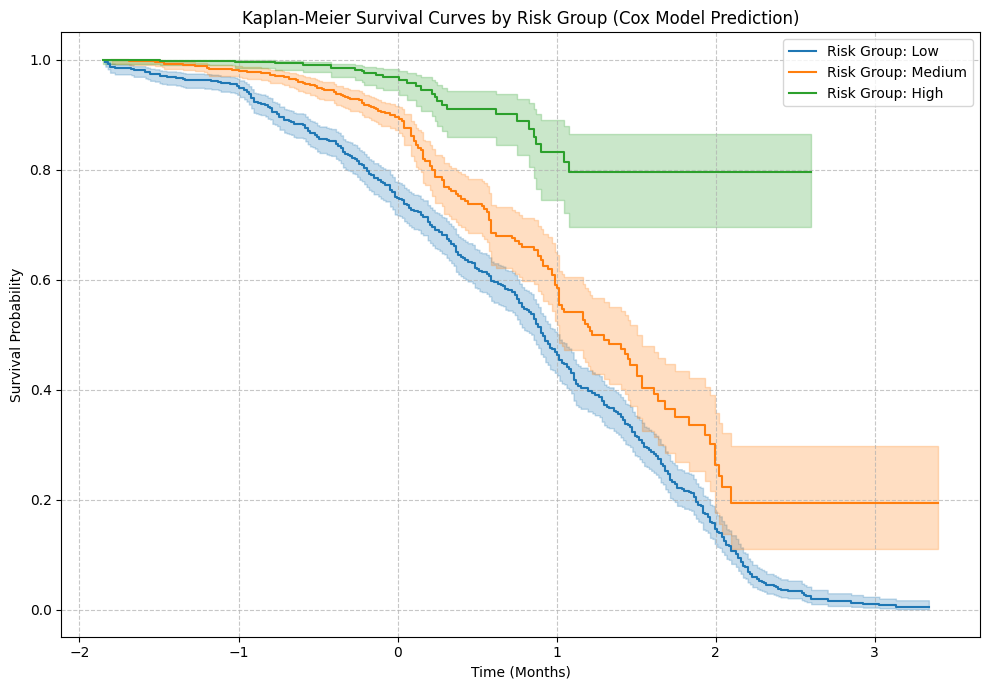

In [12]:
#12 Visual Survival Comparison Across Risk Groups

kmf = KaplanMeierFitter()

# Plot survival curves for each risk group
fig, ax = plt.subplots(figsize=(10, 7))

for name, group in df.groupby('risk_group'):
    kmf.fit(group['survival_time'], event_observed=group['event'], label=f'Risk Group: {name}')
    kmf.plot_survival_function(ax=ax, ci_show=True) # ci_show for confidence intervals

plt.title('Kaplan-Meier Survival Curves by Risk Group (Cox Model Prediction)')
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

**Step#12** In Step #12, the workflow visualizes survival probabilities across stratified risk groups using Kaplan-Meier curves. The KaplanMeierFitter from the lifelines library is applied to each subgroup—'Low', 'Medium', and 'High'—based on previously computed risk scores. For each group, the model fits survival time and event status, then plots the survival function with confidence intervals. The resulting graph displays how survival probability declines over time for each risk tier, revealing clear separation between groups and validating the prognostic utility of the Cox model. This step is crucial for interpreting model output in a clinically meaningful way and communicating risk differentiation visually.

### 13. Plot Kaplan-Meier Survival Curves by Risk Group

In [13]:
#13 Kaplan-Meier Curves by Risk Stratification

# @title step_artifacts
num_fig = "1" # @param {type:"string"}
step = 'Survival Analysis'  # @param ["Data Loading", "Data Exploration", "Data Cleaning", "Feature Engineering", "Model Training", "Model Evaluation", "Survival Analysis", "Visualization"] {type: "string"}
# upload_plt_to_gcs(num_fig, step, fig)

**Step #13** in the survival analysis pipeline involves plotting Kaplan-Meier survival curves stratified by risk group. This visualization helps assess how different patient risk categories—typically derived from clinical or molecular features—relate to survival probabilities over time. By comparing curves, researchers can evaluate the prognostic separation between groups, identify high-risk populations, and validate the clinical relevance of the risk stratification model. This step is crucial for interpreting model outputs and communicating survival differences in a clear, visual format.

**Number Section:**

num_fig = "1": This indicates that the figure generated in this step is labeled as Figure 1, likely for tracking and saving purposes in downstream reporting or cloud storage.

In [14]:
#14 Export Stratified METABRIC Dataset....Save stratified data

df.to_csv(os.path.join(output_path, 'METABRIC_stratified.csv'), index=False)

**Step#14** In this step, the stratified version of the METABRIC dataset is saved to disk as a CSV file. The code uses df.to_csv() to write the DataFrame df to a file named 'METABRIC_stratified.csv' within the specified output_path directory. The index=False argument ensures that the DataFrame’s index is excluded from the saved file, keeping the output clean and focused on the actual data columns. This step finalizes the stratification process by persisting the results for downstream analysis or sharing.